<a href="https://colab.research.google.com/github/NeoNeuron/CCN2021_TUT/blob/main/cortical_column.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

---
# DiPDE Example: Cortical column


In [ ]:
#@title Install `dipde` package
# @markdown install packages to visualize brains and electrode locations
!pip install git+https://github.com/AllenInstitute/dipde.git --user --quiet

In [1]:
# Copyright 2013 Allen Institute
# This file is part of dipde
# dipde is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# dipde is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License
# along with dipde.  If not, see <http://www.gnu.org/licenses/>.

import copy
import matplotlib.pyplot as plt
from dipde.internals.internalpopulation import InternalPopulation
from dipde.internals.externalpopulation import ExternalPopulation
from dipde.internals.network import Network
from dipde.internals.simulation import Simulation
from dipde.internals.simulationconfiguration import SimulationConfiguration
from dipde.internals.connection import Connection as Connection
import itertools
import logging
# from brian.neurongroup import network
logging.disable(logging.CRITICAL) # pragma: no cover

def get_network(dv = .0001):

    nsyn_background = {
        (23, 'e'): 1600,
        (23, 'i'): 1500,
        (4, 'e'): 2100,
        (4, 'i'): 1900,
        (5, 'e'): 2000,
        (5, 'i'): 1900,
        (6, 'e'): 2900,
        (6, 'i'): 2100
    }
    
    background_firing_rate = 8
    
    background_delay = {
        'e': 0.005,
        'i': 0.0
    }
    
    internal_population_sizes = {
        (23, 'e'): 20683,
        (23, 'i'): 5834,
        (4, 'e'): 21915,
        (4, 'i'): 5479,
        (5, 'e'): 4850,
        (5, 'i'): 1065,
        (6, 'e'): 14395,
        (6, 'i'): 2948
    }
    
    connection_probabilities = {((23,'e'),(23,'e')):.101,   ((23,'e'),(23,'i')):.135,  ((23,'e'),(4,'e')):.008,   ((23,'e'),(4,'i')):.069,   ((23,'e'),(5,'e')):.100,   ((23,'e'),(5,'i')):.055,   ((23,'e'),(6,'e')):.016,   ((23,'e'),(6,'i')):.036,
                                ((23,'i'),(23,'e')):.169,   ((23,'i'),(23,'i')):.137,  ((23,'i'),(4,'e')):.006,   ((23,'i'),(4,'i')):.003,   ((23,'i'),(5,'e')):.062,   ((23,'i'),(5,'i')):.027,   ((23,'i'),(6,'e')):.007,   ((23,'i'),(6,'i')):.001,
                                ((4,'e'),(23,'e')):.088,    ((4,'e'),(23,'i')):.032,   ((4,'e'),(4,'e')):.050,    ((4,'e'),(4,'i')):.079,    ((4,'e'),(5,'e')):.051,    ((4,'e'),(5,'i')):.026,    ((4,'e'),(6,'e')):.021,    ((4,'e'),(6,'i')):.003,
                                ((4,'i'),(23,'e')):.082,    ((4,'i'),(23,'i')):.052,   ((4,'i'),(4,'e')):.135,    ((4,'i'),(4,'i')):.160,    ((4,'i'),(5,'e')):.006,    ((4,'i'),(5,'i')):.002,    ((4,'i'),(6,'e')):.017,    ((4,'i'),(6,'i')):.001,
                                ((5,'e'),(23,'e')):.032,    ((5,'e'),(23,'i')):.075,   ((5,'e'),(4,'e')):.007,    ((5,'e'),(4,'i')):.003,    ((5,'e'),(5,'e')):.083,    ((5,'e'),(5,'i')):.060,    ((5,'e'),(6,'e')):.057,    ((5,'e'),(6,'i')):.028,
                                ((5,'i'),(23,'e')):0,       ((5,'i'),(23,'i')):0,      ((5,'i'),(4,'e')):.0003,   ((5,'i'),(4,'i')):0,       ((5,'i'),(5,'e')):.373,    ((5,'i'),(5,'i')):.316,    ((5,'i'),(6,'e')):.020,    ((5,'i'),(6,'i')):.008,
                                ((6,'e'),(23,'e')):.008,    ((6,'e'),(23,'i')):.004,   ((6,'e'),(4,'e')):.045,    ((6,'e'),(4,'i')):.106,    ((6,'e'),(5,'e')):.020,    ((6,'e'),(5,'i')):.009,    ((6,'e'),(6,'e')):.040,    ((6,'e'),(6,'i')):.066,
                                ((6,'i'),(23,'e')):0,       ((6,'i'),(23,'i')):0,      ((6,'i'),(4,'e')):0,       ((6,'i'),(4,'i')):0,       ((6,'i'),(5,'e')):0,       ((6,'i'),(5,'i')):0,       ((6,'i'),(6,'e')):.225,    ((6,'i'),(6,'i')):.144}
    
    conn_weights = {
        'e': .175*1e-3,
        'i': -.7*1e-3
    }
    
    position_dict = {
        (23, 'e'): (0,0,3),
        (23, 'i'): (0,1,3),
        (4, 'e'): (0,0,2),
        (4, 'i'): (0,1,2),
        (5, 'e'): (0,0,1),
        (5, 'i'): (0,1,1),
        (6, 'e'): (0,0,0),
        (6, 'i'): (0,1,0)
    }
    
    internal_population_settings = {'v_min': -.03, 
                                    'v_max':.015,
                                    'dv':dv,
                                    'update_method':'gmres',
                                    'tau_m':.01,
                                    'tol':1e-7,
                                    'record':True}
    
    # Create populations:
    background_population_dict = {}
    internal_population_dict = {}
    for layer, celltype in itertools.product([23, 4, 5, 6], ['e', 'i']):    
        background_population_dict[layer, celltype] = ExternalPopulation('Heaviside(t)*%s' % background_firing_rate, record=True, metadata={'layer':layer, 'celltype':celltype})
        curr_population_settings = copy.copy(internal_population_settings)
        x_pos, y_pos, z_pos = position_dict[layer, celltype]
        metadata={'layer':layer, 'celltype':celltype, 'x':x_pos, 'y':y_pos, 'z':z_pos,}
        curr_population_settings.update({'metadata':metadata})
        internal_population_dict[layer, celltype] = InternalPopulation(**curr_population_settings)
    
    # Create background connections:
    connection_list = []
    for layer, celltype in itertools.product([23, 4, 5, 6], ['e', 'i']):
        source_population = background_population_dict[layer, celltype]
        target_population = internal_population_dict[layer, celltype]
        if celltype == 'e':
            background_delay = .005
        else:
            background_delay = 0.
        curr_connection = Connection(source_population, target_population, nsyn_background[layer, celltype], weights=conn_weights['e'], delays=background_delay) 
        connection_list.append(curr_connection)
    
    # Create recurrent connections:
    for source_layer, source_celltype in itertools.product([23, 4, 5, 6], ['e', 'i']):
        for target_layer, target_celltype in itertools.product([23, 4, 5, 6], ['e', 'i']):
            source_population = internal_population_dict[source_layer, source_celltype]
            target_population = internal_population_dict[target_layer, target_celltype]
            nsyn = connection_probabilities[(source_layer, source_celltype), (target_layer, target_celltype)]*internal_population_sizes[source_layer, source_celltype]
            weight = conn_weights[source_celltype]
            curr_connection = Connection(source_population, target_population, nsyn, weights=weight, delays=0)
            connection_list.append(curr_connection)
    
    # Create simulation:
    population_list = [item for item in background_population_dict.values()] + [item for item in internal_population_dict.values()]

    def f(n):
        # print('t:', n.t)
        if n.t%.01 < 1e-10:
            print('t:', n.t)
    network = Network(population_list, connection_list, update_callback=f)
    
    return network
    
def example(show=False, save=False, network=None):
    
    # Simulation settings:
    t0 = 0.
    dt = .0002
    tf = .1
    dv = .0002
    
    if network is None:
        network = get_network(dv)
    
    internal_population_dict = {}
    for p in network.population_list:
        if isinstance(p, InternalPopulation):
            layer = p.metadata['layer']
            celltype = p.metadata['celltype']
            internal_population_dict[layer, celltype] = p
    
    # Run simulation:
    simulation_configuration = SimulationConfiguration(dt, tf, t0=t0)
    simulation = Simulation(network=network, simulation_configuration=simulation_configuration)
    simulation.run()
    print('Run Time:', network.run_time)
    
    # Visualize:
    y_label_dict = {23:'2/3', 4:'4', 5:'5', 6:'6'}

    result_dict = {}
    for row_ind, layer in enumerate([23, 4, 5, 6]):
        for plot_color, celltype in zip(['r', 'b'],['e', 'i']):
            curr_population = internal_population_dict[layer, celltype]
            result_dict[layer, celltype] = curr_population.firing_rate_record[-1]

    if show == True:  # pragma: no cover

        fig, axes = plt.subplots(nrows=4, ncols=1, **{'figsize': (4, 8)})
        for row_ind, layer in enumerate([23, 4, 5, 6]):
            for plot_color, celltype in zip(['r', 'b'], ['e', 'i']):
                curr_population = internal_population_dict[layer, celltype]
                axes[row_ind].plot(curr_population.t_record, curr_population.firing_rate_record, plot_color)


            axes[row_ind].set_xlim([0,tf])
            axes[row_ind].set_ylim(ymin=0)
            axes[row_ind].set_ylabel('Layer %s\nfiring rate (Hz)' % y_label_dict[layer])
            if layer == 5: axes[row_ind].legend(['Excitatory', 'Inhibitory'], prop={'size':10}, loc=4)

        axes[3].set_xlabel('Time (seconds)')
        fig.tight_layout()

        if save == True: plt.savefig('./cortical_column.png')

        plt.show()  # pragma: no cover

    return result_dict, simulation
    

t: 0.01
t: 0.02
t: 0.030000000000000002
t: 0.04
t: 0.05
t: 0.060000000000000005
t: 0.07
t: 0.08
t: 0.09000000000000001
t: 0.1
Run Time: 3.007322311401367


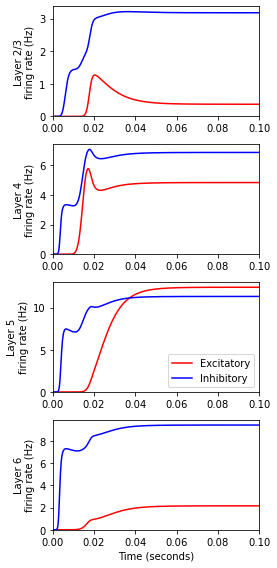

In [2]:
result_dict, simulation = example(show=True)